In [1]:
import os
import pandas as pd
import numpy as np
import glob
import datetime
from datetime import datetime
import bz2
import re
import glob
from tqdm import tqdm
import random
from datetime import timedelta

# This mutes useless warnings:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
#first preprocess the data with:
# This will take a VERY long time, I recommend running in the terminal
# !python dataloader.py

In [3]:
from data_loader import NASAAirportDataset

# this will take a while
train_ds = NASAAirportDataset('KCLT', 'data/preprocess/train')



In [4]:

# Change these times and samples
def time_sampler(n_samples, start=datetime(2022, 9, 1, 0, 0, 0), end=datetime(2023, 9, 2, 23, 0)):
    i = 0
    while i < n_samples:
        yield start + timedelta(seconds=random.randint(0, int((end - start).total_seconds())))
        i += 1

def data_itr(len):
    for time in time_sampler(len):
        yield train_ds[time]

# time_samples = [start + timedelta(seconds=random.randint(0, int((end - start).total_seconds()))) for _ in range(n_samples)]


In [5]:
import torch

for i in time_sampler(3):
    print('Flights at time', i)
    inputs, targets = train_ds[i]
    print(inputs)
    print(targets)
    # for flight_data in train_ds[i]:
    #     train model on one row of (flight_data)



Flights at time 2023-05-05 23:57:35
tensor([[-1.,  1., -1.,  ..., -1.,  1., -1.],
        [-1.,  1., -1.,  ..., -1.,  1., -1.],
        [-1., -1.,  1.,  ..., -1.,  1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1.,  1., -1.],
        [-1.,  1., -1.,  ..., -1.,  1., -1.],
        [-1., -1.,  1.,  ..., -1.,  1., -1.]], device='cuda:0')
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')
Flights at time 2023-01-18 07:57:55
tensor([], device='cuda:0', size=(0, 1326))
tensor([], device='cuda:0', size=(0, 12))
Flights at time 2023-01-29 11:21:51
tensor([[-1.,  1., -1.,  ..., -1.,  1., -1.],
        [-1.,  1., -1.,  ..., -1.,  1., -1.],
        [-1.,  1., -1.,  ..., -1.,  1., -1.],
        ...,
        [-1., -1.,  1.,  ..., -1.,  1., -1.],
        [-1., -1.,  1.,  ..., -

In [9]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# dataset = NASAAirportDataset(airport_code='KJFK', data_dir='/path/to/data', lamp_df=lamp_df, to_tensor=True)


input_dim = 1326
output_dim = 4 * 3   # 15 min intervals across 3 hours
hidden_dim = 64

class SimpleFeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleFeedForward, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleFeedForward(input_dim, hidden_dim, output_dim)
model.to('cuda')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 1000
model.train()
losses = []
# for epoch, time in (pbar := tqdm(enumerate(time_sampler(num_epochs)))):
for epoch in range(num_epochs):
    running_loss = 0.0
    epoch_len = 0
    n_steps = len(train_ds)

    for x_batch, y_batch in (pbar := tqdm(data_itr(n_steps), total=n_steps)):
        if(len(x_batch) == 0):
            pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], running_loss: {running_loss :.4f}, Loss: (no flights at timestep)")
            continue
        epoch_len = len(x_batch)
        optimizer.zero_grad()
        outputs = model(x_batch)  # forward pass
        loss = criterion(outputs, y_batch)
        if loss.isnan():
            print("Error: nan loss.... WHY?!?!?!?")
            continue
        loss.backward()  # backpropagate
        optimizer.step()  # update weights

        running_loss += loss.item() * x_batch.size(0)
        losses.append(loss)
        pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], running_loss: {running_loss :.4f}, Loss: {loss :.4f}")

    epoch_loss = running_loss / epoch_len
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss :.4f}")

print("Training completed.")




Epoch [1/1000], running_loss: 43.3101, Loss: 0.0758:   0%|          | 14/225521 [00:35<164:25:11,  2.62s/it]                

Error: nan loss.... WHY?!?!?!?


Epoch [1/1000], running_loss: 89.0518, Loss: 0.0765:   0%|          | 23/225521 [00:58<163:53:30,  2.62s/it]                  

Error: nan loss.... WHY?!?!?!?


Epoch [1/1000], running_loss: 171.1442, Loss: (no flights at timestep):   0%|          | 45/225521 [01:52<159:41:28,  2.55s/it]

Error: nan loss.... WHY?!?!?!?


Epoch [1/1000], running_loss: 171.1442, Loss: (no flights at timestep):   0%|          | 46/225521 [01:55<162:51:07,  2.60s/it]

Error: nan loss.... WHY?!?!?!?


Epoch [1/1000], running_loss: 208.1115, Loss: 0.0774:   0%|          | 54/225521 [02:15<162:33:45,  2.60s/it]                  

Error: nan loss.... WHY?!?!?!?


Epoch [1/1000], running_loss: 208.1115, Loss: 0.0774:   0%|          | 54/225521 [02:17<159:05:36,  2.54s/it]


KeyboardInterrupt: 

[0.07664141058921814, 0.0749681293964386, 0.07653726637363434, 0.07701569050550461, 0.07659517228603363, 0.07735131680965424, 0.07869382947683334, 0.07859063893556595, 0.07953338325023651, 0.0758354663848877, 0.07665195316076279, 0.07670452445745468, 0.07665063440799713, 0.07422512024641037, 0.07720277458429337, 0.07648561149835587, 0.07646579295396805, 0.07834263145923615, 0.0759909525513649, 0.0778471827507019, 0.07720672339200974, 0.07612927258014679, 0.07679622620344162, 0.07709784060716629, 0.07662677019834518, 0.07618100196123123, 0.07684239745140076, 0.07659219950437546, 0.07642849534749985, 0.07513267546892166, 0.07582420110702515, 0.07661963254213333, 0.07777098566293716, 0.07633108645677567, 0.07653187215328217, 0.07650411874055862, 0.07743028551340103]


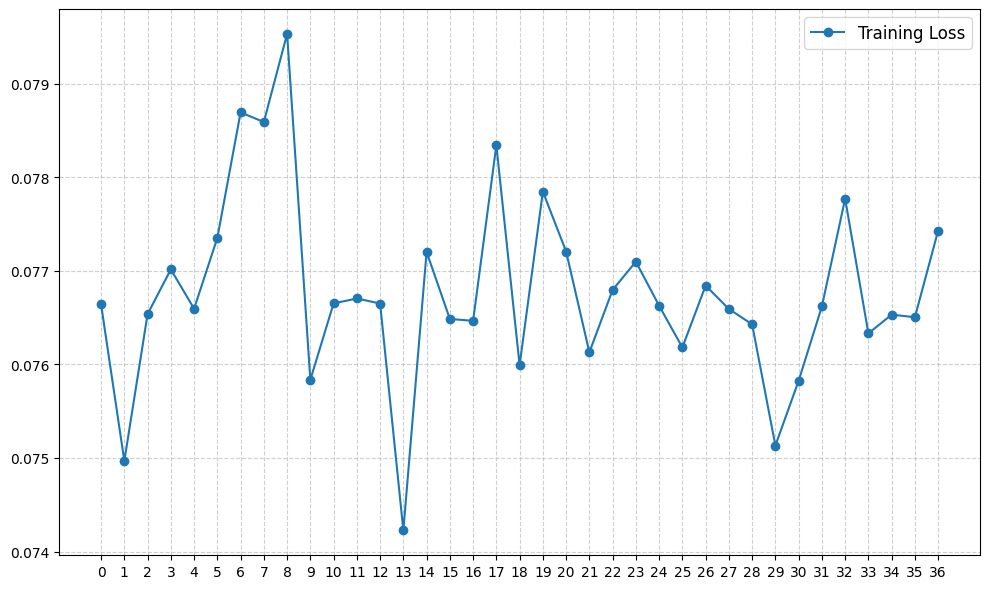

In [12]:

import matplotlib.pyplot as plt
losses = [x.item() for x in losses]
print(losses)
plt.figure(figsize=(10, 6))
plt.plot(losses, marker='o', linestyle='-', label="Training Loss")
# plt.title(title, fontsize=16)
# plt.xlabel(xlabel, fontsize=12)
# plt.ylabel(ylabel, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(len(losses)))  # Show ticks for each epoch
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()